In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Read and Clean ACS Data

In [2]:
df = pd.read_csv('../data/acs_data/usa_00018.csv')
df.head()

,YEAR,SAMPLE,SERIAL,NUMPREC,HHWT,STATEFIP,MORTAMT1,MORTAMT2,TAXINCL,INSINCL,...,MOMLOC,POPLOC,SPLOC,MOMLOC2,POPLOC2,AGE,INCTOT,INCWELFR,INCSUPP,INCEARN
0,2006,200601,1,1,88.0,1,0,0,0,0,...,0,0,0,0,0,47,36000,0,0,36000
1,2006,200601,2,4,105.0,1,590,0,1,1,...,0,0,2,0,0,59,30000,0,0,30000
2,2006,200601,2,4,105.0,1,590,0,1,1,...,0,0,1,0,0,57,1300,0,0,0
3,2006,200601,2,4,105.0,1,590,0,1,1,...,1,2,0,0,0,30,28000,0,0,28000
4,2006,200601,2,4,105.0,1,590,0,1,1,...,0,0,0,0,0,50,19000,0,0,19000


In [3]:
def clean_individual_level_data(acs_data):
    # Convert T/F vars to boolean
    acs_data.loc[:, 'TAXINCL'] = acs_data['TAXINCL'].replace({1: 0, 2: 1})
    acs_data.loc[:, 'INSINCL'] = acs_data['INSINCL'].replace({1: 0, 2: 1})

    # Replace these totals with a boolean stating whether the indiviudal received any at all
    acs_data['INCWELFR'] = acs_data['INCWELFR'] > 0
    acs_data['INCSUPP'] = acs_data['INCSUPP'] > 0

    # Add a column denoting whether someone is over 21
    acs_data["22+"] = acs_data["AGE"] >= 22
    # Add a column denoting whether someone is over 17
    acs_data["18+"] = acs_data["AGE"] >= 18
    # Add a column denoting whether someone is elderly
    acs_data["elderly"] = acs_data["AGE"] >= 60

    acs_data.drop(columns = ["AGE"], inplace = True)

    # Impute N/A and unknown incomes with 0
    acs_data.loc[:, 'INCTOT'] = acs_data['INCTOT'].replace({9999998: 0, 9999999: 0})

    # Add a col to say whether they have parents in the household
    acs_data["child_with_parents_in_hh"] = np.logical_and((acs_data['MOMLOC'] + acs_data['MOMLOC2'] + 
                                            acs_data['POPLOC'] + acs_data['POPLOC2']) > 0, 
                                            ~acs_data['22+'])
    
    # Add a col with min parent location
    acs_data['min_parent_location'] = get_nonzero_min_of_cols(acs_data, 'parents')

    # Drop parent location cols
    acs_data.drop(columns = ["MOMLOC", "POPLOC", "POPLOC2", "MOMLOC2"], inplace = True)

    # Add a col with min self and spouse location
    acs_data['min_couple_location'] = get_nonzero_min_of_cols(acs_data, 'spouse')

    # Drop pernum col
    acs_data.drop(columns = ["PERNUM"], inplace = True)

    # Add a col with utilities costs
    acs_data['annual_utilities_cost'] = (acs_data['COSTELEC'] + acs_data['COSTGAS'] + 
                                         acs_data['COSTWATR'] + acs_data['COSTFUEL'])
    
    # Drop utilies divisions columns
    acs_data.drop(columns = ["COSTELEC", "COSTGAS", "COSTWATR", "COSTFUEL"], inplace = True)

    # Add a col for the total housing cost
    acs_data['total_annual_housing_cost'] = (12 * df["RENTGRS"] + 12 * (
                                    # Multiply rent and mortgage payments by 12
                                    acs_data['MORTAMT1'] + acs_data['MORTAMT2']) + (
                                        1 - acs_data['TAXINCL']) * acs_data['PROPTX99'] + (
                                            1 - acs_data['INSINCL']) * acs_data['PROPINSR'] + (
                                                # Utilities are not included for mortgage payments, they are for rent
                                                acs_data['MORTAMT1'] > 0) * acs_data['annual_utilities_cost'] +
                                                # Add condo fees and mobile home costs
                                                acs_data['CONDOFEE'] + acs_data['MOBLHOME']
                                                # Split evenly across all household members
                                                ) / df['NUMPREC']
    
    # Drop housing costs divisions columns
    acs_data.drop(columns = ["RENTGRS", "MORTAMT1", "MORTAMT2", "annual_utilities_cost",
                             "TAXINCL", "INSINCL", "PROPTX99", "PROPINSR", "NUMPREC"], inplace = True)

    return acs_data

def get_nonzero_min_of_cols(df, parents_or_spouse):
    if parents_or_spouse == 'parents':
        cols = ["MOMLOC", "POPLOC", "POPLOC2", "MOMLOC2"]
    elif parents_or_spouse == 'spouse':
        cols = ["PERNUM", "SPLOC"]
    else:
        raise ValueError("parents_or_spouse must equal 'parents' or 'spouse'")
    df = df[cols]
    # Ensure that the min will not be a 0, which indicates that there is no one with
    # this relationship in the household
    df.replace({0: 1000}, inplace = True)
    return df.min(axis = 1).replace({1000: 0})

In [4]:
df = clean_individual_level_data(df)
df

/var/folders/m3/f23mtyd11999h6hwmgcqzz9c0000gn/T/ipykernel_94740/3726842673.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace({0: 1000}, inplace = True)
/var/folders/m3/f23mtyd11999h6hwmgcqzz9c0000gn/T/ipykernel_94740/3726842673.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace({0: 1000}, inplace = True)


,YEAR,SAMPLE,SERIAL,HHWT,STATEFIP,CONDOFEE,MOBLHOME,HHINCOME,PERWT,SUBFAM,...,INCWELFR,INCSUPP,INCEARN,22+,18+,elderly,child_with_parents_in_hh,min_parent_location,min_couple_location,total_annual_housing_cost
0,2006,200601,1,88.0,1,0,0,36000,87.0,0,...,False,False,36000,True,True,False,False,0,1,7560.00
1,2006,200601,2,105.0,1,0,280,78300,106.0,0,...,False,False,30000,True,True,False,False,0,1,8030.75
2,2006,200601,2,105.0,1,0,280,78300,107.0,0,...,False,False,0,True,True,False,False,0,1,8030.75
3,2006,200601,2,105.0,1,0,280,78300,114.0,0,...,False,False,28000,True,True,False,False,1,3,8030.75
4,2006,200601,2,105.0,1,0,280,78300,150.0,0,...,False,False,19000,True,True,False,False,0,4,8030.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56168391,2023,202301,1519008,77.0,56,0,0,145000,78.0,0,...,False,False,80000,True,True,False,False,0,1,21136.50
56168392,2023,202301,1519008,77.0,56,0,0,145000,62.0,0,...,False,False,0,True,True,True,False,0,1,21136.50
56168393,2023,202301,1519009,75.0,56,0,0,75000,76.0,0,...,False,False,75000,True,True,True,False,0,1,25273.00
56168394,2023,202301,1519010,37.0,56,0,0,43600,37.0,0,...,False,False,0,True,True,True,False,0,1,3000.00


Group by SNAP Unit

In [5]:
def add_snap_unit_ref_person(person):
    """
    Create variable called snap unit ref person location
    """
    # If child with parents in the house
    if person["child_with_parents_in_hh"]:
        # SNAP Unit reference person is parent with minimum PERNUM
        return person['min_parent_location']
    # If adult
    elif person["18+"]:
        return person['min_couple_location']
    # If they are a child without parents in the house
    else:
        return 1

In [6]:
df['SNAP Unit Reference Person'] = df.apply(add_snap_unit_ref_person, axis = 1)

In [7]:
# Add a column that will sum to the size of the family unit after grouping
df["SNAP UNIT SIZE"] = 1

# Perform the grouping and aggregation
grouped_by_snap_unit = df[["YEAR", "SERIAL", "SNAP Unit Reference Person", "PERWT", 
                           "INCTOT", "STATEFIP", "INCWELFR", "INCSUPP", "SNAP UNIT SIZE", "18+",
                           "total_annual_housing_cost", "elderly", 'INCEARN', "SPLOC"]
                           ].groupby(["YEAR", "SERIAL", "SNAP Unit Reference Person", "STATEFIP"]).sum()

df = None
grouped_by_snap_unit.reset_index(inplace=True)
grouped_by_snap_unit

,YEAR,SERIAL,SNAP Unit Reference Person,STATEFIP,PERWT,INCTOT,INCWELFR,INCSUPP,SNAP UNIT SIZE,18+,total_annual_housing_cost,elderly,INCEARN,SPLOC
0,2006,1,1,1,87.0,36000,0,0,1,1,7560.00,0,36000,0
1,2006,2,1,1,213.0,31300,0,0,2,2,16061.50,0,30000,3
2,2006,2,3,1,114.0,28000,0,0,1,1,8030.75,0,28000,0
3,2006,2,4,1,150.0,19000,0,0,1,1,8030.75,0,19000,0
4,2006,3,1,1,316.0,0,0,0,2,1,2.00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30039123,2023,1519007,3,56,69.0,13400,0,0,1,1,8.25,0,13400,0
30039124,2023,1519007,4,56,68.0,6000,0,0,1,1,8.25,0,6000,0
30039125,2023,1519008,1,56,140.0,145000,0,0,2,2,42273.00,1,80000,3
30039126,2023,1519009,1,56,76.0,75000,0,0,1,1,25273.00,1,75000,0


Read in necessary economic data

In [8]:
fpl_table = pd.read_csv('../data/administrative_info/cleaned/fpl.csv', index_col = 0)
fpl_table.set_index("Year", inplace=True)

In [9]:
sd_table = pd.read_csv('../data/administrative_info/cleaned/standard_deductions.csv', index_col = 0)
sd_table.set_index("Year", inplace=True)

Calculate Eligibility

In [ ]:
def calc_federal_poverty_level(year: int, snap_unit_size: int) -> float:
    """
    Given a year and a snap unit size, calculate the income at which
    that household would reach the FPL.
    Args:
        year (int)
        snap_unit_size (int)
    """
    fpl_table_for_year = fpl_table.loc[year]
    fpl_year = (fpl_table_for_year['First Person'] 
                + (snap_unit_size - 1) * fpl_table_for_year['Each Additional Person'])
    return fpl_year

def calc_net_income(gross_income: float, earned_income: float, year: int, 
                    housing_costs: float, sploc: int):
    """
    Calculate the total annual net income for a SNAP Unit
    Args:
        gross_income (float): The SNAP Unit's annual gross income
        earned_income (float): The SNAP Unit's annual earned income
        year (int): The year this SNAP Unit was surveyed
        housing_costs (float): The SNAP Unit's annual housing costs
        sploc (int): > 0 if this is a couple, otherwise 0
        # think we only need whether they are a single head of household
        # or not, separate vs joing filing for couples is the same for standard
    """
    adj_income = gross_income - 0.2 * earned_income
    # This code does not include adjustments based on housing costs or standard deductions
    # Our snap gap estimates are currenrtly high, adding those adjustments will make them higher
    return adj_income

def add_snap_eligibility(acs_data: pd.DataFrame) -> pd.DataFrame:
    """
    Given a dataframe of ACS data, add a column that indicates whether
    a household was eligible to receive SNAP benefits.
    Args:
        acs_data (pd.DataFrame):
            YEAR (int): the year this household appeared in the ACS
            PERWT (float): the summed weights of each person in the family unit
            STATEFIP (int): the FIPS code for the state
            INCTOT (int): the summed gross income of each person in the family unit
            FAMUNIT SIZE (int): the size of the family unit
            INCWELFR (int): the total general cash assistance (generally TANF) received by the family unit
            INCSUPP (int): the total SSI received by the family unit
            130_fpl (float): 130% of the federal poverty level for a family unit of that size in that year
            SPLOC (int): > 0 if this is a couple, otherwise 0
    """
    # Add a column with the net income for the SNAP unit
    acs_data['net_income'] = acs_data.apply(lambda row: calc_net_income(
                                    row['INCTOT'], row['INCEARN'],
                                    row['YEAR'], row['total_annual_housing_cost'],
                                    row['SPLOC']), axis = 1)

    # Add a column that contains FPL based on year and SNAP Unit size
    acs_data['fpl'] = acs_data.apply(lambda row: calc_federal_poverty_level(
                                    row['YEAR'], row['SNAP UNIT SIZE']), axis = 1)
    # Add a column with 130% of the FPL
    acs_data['130_fpl'] = 1.3 * acs_data['fpl']
    # Add a column for snap eligibility
    acs_data['FOODSTMP Eligible'] = acs_data.apply(determine_eligibility, axis = 1)

    return acs_data

def determine_eligibility(acs_row):
    # All units where the adult members all receive TANF are eligible
    if acs_row['INCWELFR'] >= acs_row["18+"]:
        return True
    # All units where the adult members all receive SSI are eligible
    if acs_row['INCSUPP'] >= acs_row["18+"] :
        return True
    # All other units must pass the net income test
    if acs_row['net_income'] <= acs_row['fpl']:
        # Elderly and disabled units only need to pass the net income test
        # TODO add condition for disabled
        if acs_row['elderly'] > 0:
            return True
        # Other units must also pass the gross income test
        elif acs_row['INCTOT'] <= acs_row['130_fpl']:
            return True
        
    return False

def est_prop_eligible(acs_with_eligibility: pd.DataFrame) -> pd.DataFrame:
    """
    Estimate the proportion of individuals in the ACS eligible for SNAP in each state, each year
    Args:
        acs_with_eligibility (df):
            YEAR (int): the year this household appeared in the ACS
            PERWT (float): the summed weights of each person in the family unit
            STATEFIP (int): the FIPS code for the state
            FOODSTMP Eligible (bool): whether that household is eligible for SNAP
    """ 
    acs_with_eligibility = acs_with_eligibility[["YEAR", "STATEFIP", "FOODSTMP Eligible", "PERWT"]]

    est_total = lambda x: sum(x["PERWT"] * x['FOODSTMP Eligible'])
    total_df = pd.DataFrame(acs_with_eligibility.groupby(["YEAR", "STATEFIP"]).apply(est_total))
    total_df.rename(columns={0:"Est Num Eligible"}, inplace=True)
    total_df = total_df.reset_index()

    est_prop = lambda x: sum(x["PERWT"] * x['FOODSTMP Eligible']) / sum(x["PERWT"])
    prop_df = pd.DataFrame(acs_with_eligibility.groupby(["YEAR", "STATEFIP"]).apply(est_prop))
    prop_df.rename(columns={0:"Est Proportion Eligible"}, inplace=True)
    prop_df = prop_df.reset_index()

    df = pd.merge(total_df, prop_df, on=["YEAR", "STATEFIP"])

    return df

In [11]:
with_eligibility = add_snap_eligibility(grouped_by_snap_unit)
grouped_by_snap_unit = None

In [12]:
prop_eligible = est_prop_eligible(with_eligibility)
with_eligibility = None
prop_eligible

/var/folders/m3/f23mtyd11999h6hwmgcqzz9c0000gn/T/ipykernel_94740/3156745242.py:113: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_df = pd.DataFrame(acs_with_eligibility.groupby(["YEAR", "STATEFIP"]).apply(est_total))
/var/folders/m3/f23mtyd11999h6hwmgcqzz9c0000gn/T/ipykernel_94740/3156745242.py:118: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prop_df = pd.DataFrame(acs_with_eligibility.groupby(["YEA

,YEAR,STATEFIP,Est Num Eligible,Est Proportion Eligible
0,2006,1,2083840.0,0.453104
1,2006,2,274527.0,0.409709
2,2006,4,2752946.0,0.446449
3,2006,5,1264635.0,0.449908
4,2006,6,16726008.0,0.458780
...,...,...,...,...
913,2023,51,3342231.0,0.383473
914,2023,53,2873812.0,0.367830
915,2023,54,721985.0,0.407885
916,2023,55,2207396.0,0.373442


In [13]:
prop_eligible.rename(columns= {"STATEFIP": "STATEFIPS"}, inplace = True)
prop_eligible.to_csv('../data/estimates/eligibility_estimates/prop_eligible.csv')

### Estimate the SNAP Gaps

In [14]:
enrollments = pd.read_csv('../data/state_snap_enrollments/cleaned_enrollments/2005-2024.csv', index_col=0)
enrollments.rename(columns = {'State': "STATEFIPS", "Year": "YEAR"}, inplace = True)
enrollments

,STATEFIPS,Enrolled Individuals,YEAR
0,9,2.041455e+05,2005
1,23,1.529101e+05,2005
2,25,3.681224e+05,2005
3,33,5.231008e+04,2005
4,36,1.754861e+06,2005
...,...,...,...
4,15,1.620474e+05,2024
5,16,1.307473e+05,2024
6,32,5.046856e+05,2024
7,41,7.566747e+05,2024


In [15]:
snap_gaps = pd.merge(prop_eligible, enrollments, 'inner', on = ['STATEFIPS', 'YEAR'])
snap_gaps['SNAP Gap'] = 1 - snap_gaps['Enrolled Individuals'] / snap_gaps['Est Num Eligible']
snap_gaps = snap_gaps[["YEAR", "STATEFIPS", "SNAP Gap"]]
snap_gaps

,YEAR,STATEFIPS,SNAP Gap
0,2006,1,0.737655
1,2006,2,0.791812
2,2006,4,0.803563
3,2006,5,0.695652
4,2006,6,0.880446
...,...,...,...
895,2023,51,0.747827
896,2023,53,0.688119
897,2023,54,0.574448
898,2023,55,0.679568


In [16]:
snap_gaps.to_csv('../data/estimates/SNAP_gap_estimates/snap_gap_estimates.csv')

### Plot Creation

/var/folders/m3/f23mtyd11999h6hwmgcqzz9c0000gn/T/ipykernel_94740/125810493.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


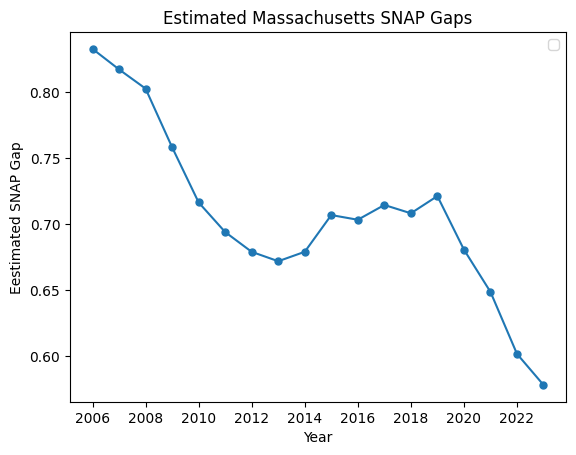

In [17]:
mass_snap_gaps = snap_gaps[snap_gaps["STATEFIPS"] == 25]
years = pd.to_datetime(mass_snap_gaps['YEAR'].astype(str), format="%Y")
plt.plot(years, mass_snap_gaps["SNAP Gap"], linestyle = '-', marker = 'o', markersize = 5)#color = 'black') #,label = "Massachusetts")
plt.legend()
plt.title("Estimated Massachusetts SNAP Gaps")
plt.xlabel("Year")
plt.ylabel("Eestimated SNAP Gap")
plt.savefig('../output/snap_gaps/mass_snap_gaps.png')

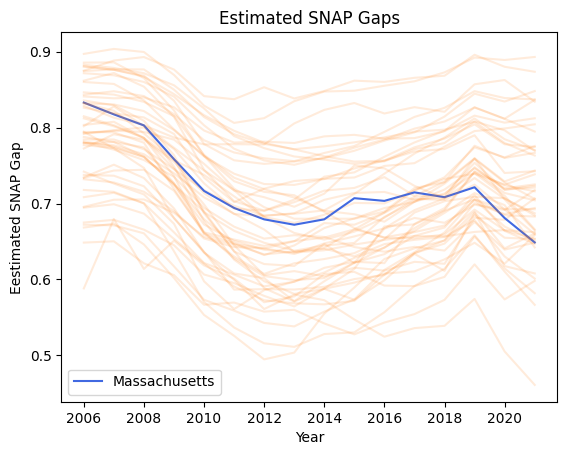

In [18]:
for state in snap_gaps["STATEFIPS"].unique():
    state_snap_gaps = snap_gaps[(snap_gaps["STATEFIPS"] == state) & (snap_gaps["YEAR"] <= 2021)]
    is_mass = state == 25
    years = pd.to_datetime(state_snap_gaps['YEAR'].astype(str), format="%Y")

    plt.plot(years, state_snap_gaps["SNAP Gap"],
             color="royalblue" if is_mass else "C1",
             alpha=1 if is_mass else 0.15,
             label="Massachusetts" if is_mass else None)

plt.legend()
plt.title("Estimated SNAP Gaps")
plt.xlabel("Year")
plt.ylabel("Eestimated SNAP Gap")
plt.savefig('../output/snap_gaps/all_state_snap_gaps.png')